# Graph Cut Segmentation

In this part image will be segmented into foreground-background using *Markov random fields* (MRF) and graph cuts.


In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [ ]:
USE_NETWORKX = False 

In [3]:
# Some imports and helper functions
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import time
import cv2
if USE_NETWORKX:
    import networkx as nx
    from networkx.algorithms.flow import preflow_push
else:
    import pygco

def draw_mask_on_image(image, mask, color=(0, 255, 255)):
    """Return a visualization of a mask overlaid on an image."""
    result = image.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    outline = dilated > mask
    result[mask == 1] = (result[mask == 1] * 0.4 + 
                         np.array(color) * 0.6).astype(np.uint8)
    result[outline] = color
    return result

ModuleNotFoundError: No module named 'pygco'

## Mask Initialization

First, manually create initial boxes of foreground and background regions.

We will use these to build color models. That is, to model the probability of a pixel color occuring, given either that it is a foreground or a background pixel.

<IPython.core.display.Javascript object>


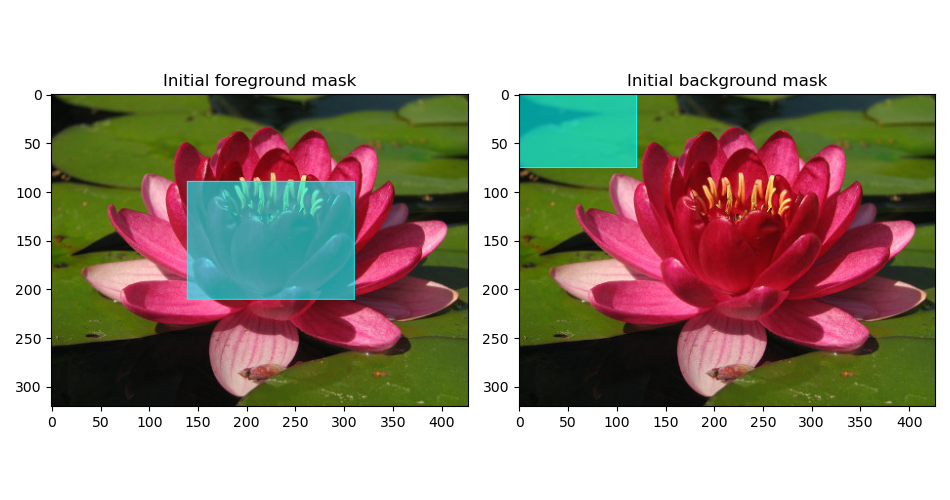

In [ ]:
im = imageio.imread('lotus320.jpg')
h,w = im.shape[:2]

# Set up initial foreground and background
# regions for building the color model
init_fg_mask = np.zeros([h, w])
init_bg_mask = np.zeros([h, w])

# Now set some rectangular region of the initial foreground mask to 1.
# This should be a part of the image that is fully foreground.
# The indices in the following line are just an example,
# and they need to be corrected so that only flower pixels are included
# init_fg_mask[10:20, 15:30] = 1

# Same for the background (replace the indices)
# init_bg_mask[60:90, 50:110] = 1

init_fg_mask[90:210, 140:310] = 1
init_bg_mask[0:75, 0:120] = 1

fig, axes = plt.subplots(1, 2, figsize=(9.5,5))
axes[0].set_title('Initial foreground mask')
axes[0].imshow(draw_mask_on_image(im, init_fg_mask))
axes[1].set_title('Initial background mask')
axes[1].imshow(draw_mask_on_image(im, init_bg_mask))
fig.tight_layout()
fig.show()

## Color Modeling by Histograms

We will use color histograms (i.e. the relative frequencies of quantized colors) in the respective region of the image defined by the boxes. In other words, we model the color simply as a discretized, categorical random variable.

Implement the function `calculate_histogram`. It takes as input the image `im` with values in the range $[0, 255]$ and a `mask` the same size as the image. The mask is 1 at the positions of the image where the histogram should be computed, zero elsewhere. The final parameter `n_bins` defines how many bins should be used in the histogram along each dimension. The function **returns a 3-dimensional array** of shape `[n_bins, n_bins, n_bins]`, containing the relative frequency for each `(r, g, b)` color bin within the region of the image defined by the mask.

In [ ]:
def calculate_histogram(im, mask, n_bins):
    histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
    
    # convert values to range of bins
    binned_im = (im.astype(np.float32)/256*n_bins).astype(int)

    for y in range(binned_im.shape[0]):
        for x in range(binned_im.shape[1]):
            if mask[y, x] != 0:
                histogram[binned_im[y, x, 0],
                          binned_im[y, x, 1], 
                          binned_im[y, x, 2]] += 1
                
    # normalize
    histogram /= np.sum(histogram)
    
    return histogram

<IPython.core.display.Javascript object>


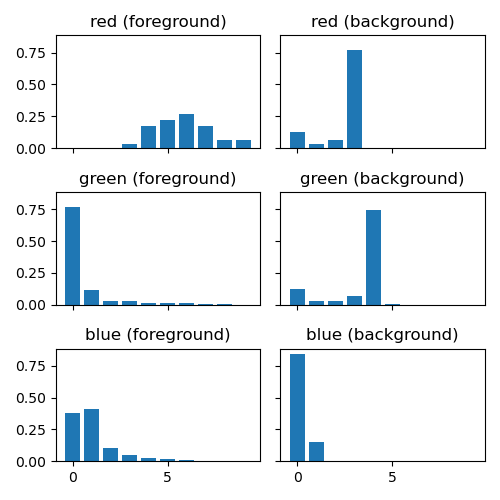

In [6]:
n_bins = 10
fg_histogram = calculate_histogram(im, init_fg_mask, n_bins)
bg_histogram = calculate_histogram(im, init_bg_mask, n_bins)

fig, axes = plt.subplots(
    3, 2, figsize=(5,5), sharex=True, 
    sharey=True, num='Relative frequency of color bins')

x = np.arange(n_bins)
axes[0,0].bar(x, np.sum(fg_histogram, (1, 2)))
axes[0,0].set_title('red (foreground)')
axes[1,0].bar(x, np.sum(fg_histogram, (0, 2)))
axes[1,0].set_title('green (foreground)')
axes[2,0].bar(x, np.sum(fg_histogram, (0, 1)))
axes[2,0].set_title('blue (foreground)')

axes[0,1].bar(x, np.sum(bg_histogram, (1, 2)))
axes[0,1].set_title('red (background)')
axes[1,1].bar(x, np.sum(bg_histogram, (0, 2)))
axes[1,1].set_title('green (background)')
axes[2,1].bar(x, np.sum(bg_histogram, (0, 1)))
axes[2,1].set_title('blue (background)')
fig.tight_layout()
fig.show()

## Foreground Probability Map

The next step in the segmentation process is to estimate a probability map: For each pixel we want to estimate the probability that it belongs to the foreground. This will be used as basis for the unary potential.

The function `foreground_pmap(im, fg_histogram, bg_histogram)` takes the image `im` and the two histograms `fg_histogram`, `bg_histogram` estimated from the foreground region and the background region respecively. It returns an array of shape $\texttt{height}\times\texttt{width}$ containing the probability of each pixel belonging to the foreground. To estimate the required probability $p(c|[r, g, b])$ from the computed histograms, a class prior $p(c)$ of $0.5$ is used, which means that both foreground and background pixels are equally likely a priori. 

Bayes' theorem is applied to this case:

$$
p(c\ |\ r,g,b) = \frac{p(c) \cdot p(r,g,b\ |\ c)}{p(r,g,b)} = \frac{p(c)\cdot p(r,g,b\ |\ c)}{\sum_{\tilde{c}} p(\tilde{c}) \cdot p(r,g,b\ |\ \tilde{c}) }
$$

In [ ]:
def foreground_pmap(im, fg_histogram, bg_histogram):

    h, w, c = im.shape
    n_bins = len(fg_histogram)
    binned_im = (im.astype(np.float32)/256*n_bins).astype(int)
    
    # prior probabilities
    p_fg = 0.5
    p_bg = 1 - p_fg
    
    # extract fg & bg prob from histograms
    p_rgb_given_fg = fg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1], 
                                  binned_im[:, :, 2]]
    
    p_rgb_given_bg = bg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1],
                                  binned_im[:, :, 2]]
    
    p_fg_given_rgb = (p_fg * p_rgb_given_fg /
                      (p_fg * p_rgb_given_fg + p_bg * p_rgb_given_bg))
    return p_fg_given_rgb

<IPython.core.display.Javascript object>


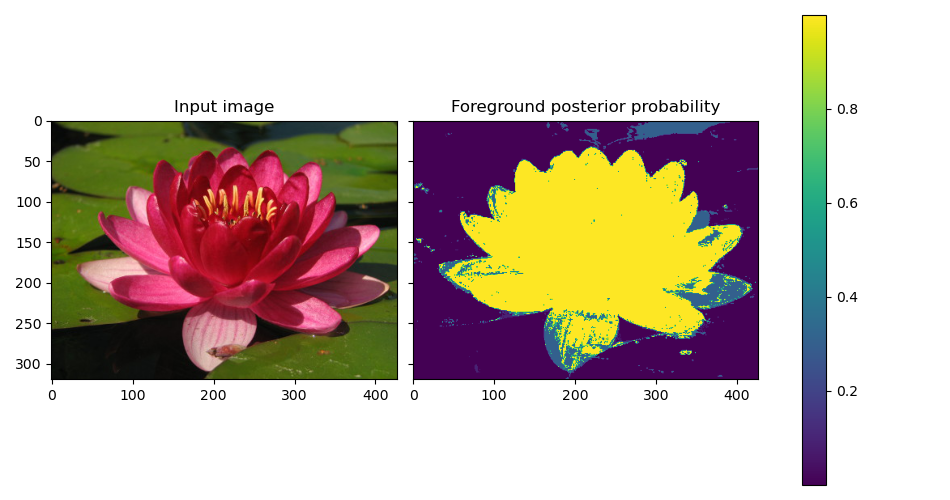

In [8]:
foreground_prob = foreground_pmap(im, fg_histogram, bg_histogram)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].imshow(im)
axes[0].set_title('Input image')
im_plot = axes[1].imshow(foreground_prob, cmap='viridis')
axes[1].set_title('Foreground posterior probability')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
foreground_map = (foreground_prob > 0.5)
fig.show()

Overall, we have a high probability of the flower to belong to the foreground and a low probability of the green leaves to belong to the foreground. Some patches are different, though, there some "high-probability-sprinkles" on the left side and there are also areas in the petals and in the top where the posterior is close to 0.5.

## Unary Potentials
Use the previously computed probability map `foreground_map` to compute the unary potential for both foreground and background.

This function `unary_potentials(probability_map, unary_weight)` uses the `probability_map` and a scalar weighting factor to compute the unary potentials. It returns a matrix of the same size as the probability matrix.

<IPython.core.display.Javascript object>


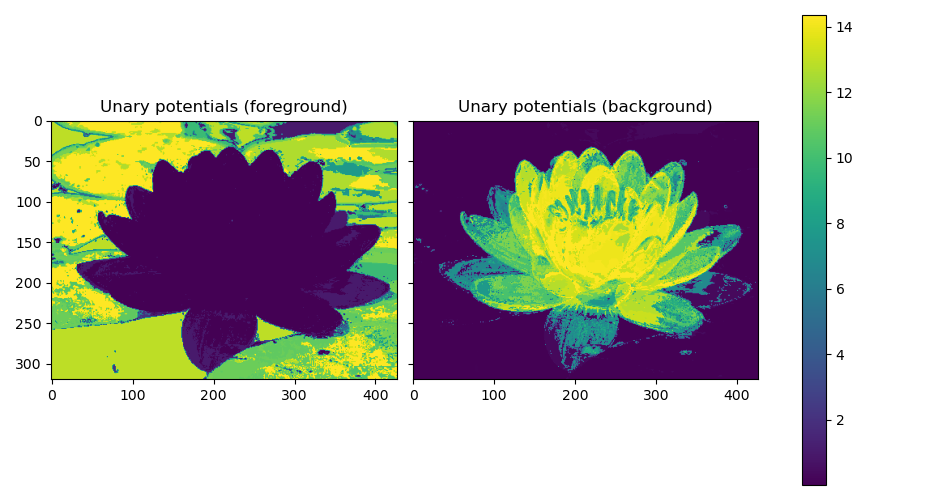

In [ ]:
def unary_potentials(probability_map, unary_weight):
    return -unary_weight * np.log(probability_map)

unary_weight = 1
unary_fg = unary_potentials(foreground_prob, unary_weight)
unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].imshow(unary_fg)
axes[0].set_title('Unary potentials (foreground)')
im_plot = axes[1].imshow(unary_bg)
axes[1].set_title('Unary potentials (background)')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
fig.show()

The probability in the middle of the flower is high, due to the negation the unary potentials are low.

## Pairwise Potentials

Create a function to compute the prefactor $w_p$ of the pairwise potential for two specific pixels, where `im` is the image, `(x1, y1), (x2, y2)` are the pixel coordinates in the image and the last parameter is the weight $\omega_p$ for the pairwise potential. (Do not confuse `(x1, y1), (x2, y2)` with the $X_j, Y_j$ from the top of the page. There $\mathcal X$ was the label and $\mathcal Y$ the pixel value, here they are the $x$ and $y$ coordinates in the image) 


In [ ]:
def pairwise_potential_prefactor(im, x1, y1, x2, y2, pairwise_weight):
    return pairwise_weight #* np.exp(-1e-1*np.sum((im[y1,x1]-im[y2,x2])**2))

Using the functions from the previous task, implement a function to compute all the pairwise potentials for the image using 4-neighborhoods. That means only the top, bottom, left and right neighboring pixels should be connected to a given pixel.

The function `pairwise_potentials` returns the `edges` (represented as index pairs) and an array `costs` containing the corresponding edge costs (i.e. the value of the pairwise potential prefactor). A linearized index is used instead of (x,y)-coordinates for the edge indices.


In [ ]:
def coords_to_index(x, y, width):
    return y * width + x

def pairwise_potentials(im, pairwise_weight):
    edges = []
    costs = []

    im = im.astype(np.float32)/255
    h, w = im.shape[:2]
    for y in range(h):
        for x in range(w):
            # Neighbor coordinates
            xs_neigh = x + np.array([0, 1, 0, -1])
            ys_neigh = y + np.array([-1, 0, 1, 0])
            
            # Make sure neighbors are within image
            mask = (xs_neigh >= 0) & (xs_neigh < w) & (ys_neigh >= 0) & (ys_neigh < h)
            xs_neigh = xs_neigh[mask]
            ys_neigh = ys_neigh[mask]
            
            center_index = coords_to_index(x, y, w)
            for x_neigh, y_neigh in zip(xs_neigh, ys_neigh):
                cost = pairwise_potential_prefactor(
                    im, x, y, x_neigh, y_neigh, pairwise_weight)
                neighbor_index = coords_to_index(x_neigh, y_neigh, w)
                edges.append((center_index, neighbor_index))
                costs.append(cost)
                
    edges = np.array(edges)
    costs = np.array(costs)
    return edges, costs

pairwise_edges, pairwise_costs = pairwise_potentials(im, pairwise_weight=5)

<IPython.core.display.Javascript object>


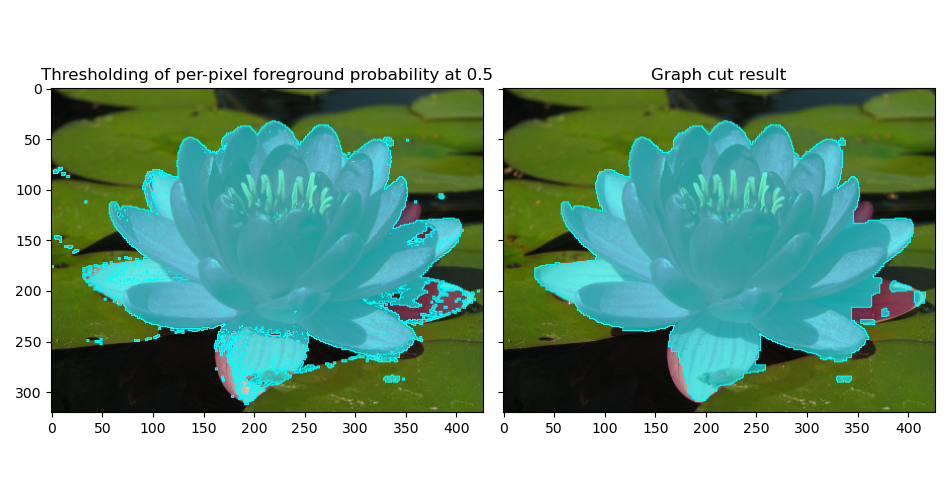

In [12]:
def graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs):
    if USE_NETWORKX:

        graph = nx.Graph()
        s = object()
        t = object()

        edges = []
        for i, cost in enumerate(unary_bg.flat):
            edges.append((s, i, cost))
        for i, cost in enumerate(unary_fg.flat):
            edges.append((i, t, cost))
        for (i,j), cost in zip(pairwise_edges, pairwise_costs):
            edges.append((i, j, cost))

        graph.add_weighted_edges_from(edges, 'capacity')

        nodes_connected_to_s = nx.minimum_cut(
            graph, s, t, flow_func=preflow_push)[1][0]

        fg_pixel_indices = list(set(nodes_connected_to_s) - {s})
        labels = np.zeros_like(unary_fg, dtype=np.int)
        labels.flat[fg_pixel_indices] = 1
        return labels
    else:
        unaries = np.stack([unary_bg.flat, unary_fg.flat], axis=-1)
        labels = pygco.cut_general_graph(
            pairwise_edges, pairwise_costs, unaries, 
            1-np.eye(2), n_iter=-1, algorithm='swap')
        return labels.reshape(unary_fg.shape)

graph_cut_result = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].set_title('Thresholding of per-pixel foreground probability at 0.5')
axes[0].imshow(draw_mask_on_image(im, foreground_prob>0.5))
axes[1].set_title('Graph cut result')
axes[1].imshow(draw_mask_on_image(im, graph_cut_result))
fig.tight_layout()
fig.show()

Borders get a lot smoother, small misclassifications disappear. Some areas are still classified wrongly. If the weight is decreased, the classification starts to look more like the thresholding image. For bigger weights the classification-borders tend to become straight lines.